# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

Почему-то у меня не работает !wget, поэтому вот так загружаю данные

In [28]:
# import urllib.request
# 
# url = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
# filename = "petfaces.tar.gz"
# 
# try:
#     urllib.request.urlretrieve(url, filename)
#     print("Файл успешно загружен:", filename)
# except Exception as e:
#     print("Произошла ошибка при загрузке файла:", e)


Далее проверим доступные утсрояйства для обучения

In [23]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Доступные устройства для CUDA:")
    for i in range(torch.cuda.device_count()):
        print(f"Устройство {i}: {torch.cuda.get_device_name(i)}")
        cuda_version = torch.version.cuda
        print("Версия CUDA:", cuda_version)
else:
    print("CUDA недоступен. Используется CPU.")


Доступные устройства для CUDA:
Устройство 0: NVIDIA GeForce RTX 3060 Laptop GPU
Версия CUDA: 11.8


Доступна видеокарта и это очень хорошо!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## Бинарная классификация
Сначала решим задачу бинарной классификации. Для этого создадим две папки. Одну с кошками - одно с собаками. 

In [30]:
import os
import shutil

source_dir = r"A:\Учёба\3 курс\ai\ai-lab-b2-convolutional-networks-Kiyoakiii-main\petfaces"

target_dir = r"A:\Учёба\3 курс\ai\ai-lab-b2-convolutional-networks-Kiyoakiii-main\new_petfaces"

os.makedirs(os.path.join(target_dir, "cat"), exist_ok=True)
os.makedirs(os.path.join(target_dir, "dog"), exist_ok=True)

for breed in os.listdir(source_dir):
    if breed.startswith("cat"):
        source_breed_dir = os.path.join(source_dir, breed)
        target_breed_dir = os.path.join(target_dir, "cat")
        for filename in os.listdir(source_breed_dir):
            shutil.copy(os.path.join(source_breed_dir, filename), target_breed_dir)

for breed in os.listdir(source_dir):
    if breed.startswith("dog"):
        source_breed_dir = os.path.join(source_dir, breed)
        target_breed_dir = os.path.join(target_dir, "dog")
        for filename in os.listdir(source_breed_dir):
            shutil.copy(os.path.join(source_breed_dir, filename), target_breed_dir)

print("Фотографии котов и собак были успешно перемещены.")


Фотографии котов и собак были успешно перемещены.


In [6]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split


data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

data_dir = "new_petfaces"

image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

train_indices, test_indices = train_test_split(list(range(len(image_dataset))), test_size=0.2, stratify=image_dataset.targets, random_state=42)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32
train_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=test_sampler)

In [7]:
print(f"Количество классов в train: {len(train_loader.dataset.classes)} \nКоличество классов в test: {len(test_loader.dataset.classes)}")

Количество классов в train: 2 
Количество классов в test: 2


Теперь можно создать архитектуру моделей и обучить их. Обе модели будут иметь несколько сверточных слоев с активацией `ReLU`, слои пулинга для уменьшения размерности и полносвязанные слои в конце. Однако, для второй модели (мультиклассовой классификации) количество выходных нейронов в последнем полносвязном слое = количеству классов.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Бинарная классификация (кошка или собака)
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
binary_model = BinaryClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(binary_model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    binary_model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = binary_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)
    
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    binary_model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = binary_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_losses.append(running_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)
    
    print('[%d] Train Loss: %.3f, Test Loss: %.3f, Train Accuracy: %.3f, Test Accuracy: %.3f' %
          (epoch + 1, train_losses[-1], test_losses[-1], train_accuracy[-1], test_accuracy[-1]))

print('Finished Training')


[1] Train Loss: 0.650, Test Loss: 0.645, Train Accuracy: 0.655, Test Accuracy: 0.656
[2] Train Loss: 0.636, Test Loss: 0.647, Train Accuracy: 0.655, Test Accuracy: 0.656
[3] Train Loss: 0.630, Test Loss: 0.619, Train Accuracy: 0.655, Test Accuracy: 0.656
[4] Train Loss: 0.614, Test Loss: 0.603, Train Accuracy: 0.655, Test Accuracy: 0.664
[5] Train Loss: 0.573, Test Loss: 0.554, Train Accuracy: 0.695, Test Accuracy: 0.728
[6] Train Loss: 0.521, Test Loss: 0.497, Train Accuracy: 0.752, Test Accuracy: 0.751
[7] Train Loss: 0.505, Test Loss: 0.484, Train Accuracy: 0.754, Test Accuracy: 0.753
[8] Train Loss: 0.466, Test Loss: 0.434, Train Accuracy: 0.786, Test Accuracy: 0.792
[9] Train Loss: 0.428, Test Loss: 0.420, Train Accuracy: 0.814, Test Accuracy: 0.792
[10] Train Loss: 0.384, Test Loss: 0.380, Train Accuracy: 0.838, Test Accuracy: 0.829
[11] Train Loss: 0.351, Test Loss: 0.355, Train Accuracy: 0.854, Test Accuracy: 0.851
[12] Train Loss: 0.317, Test Loss: 0.420, Train Accuracy: 0.864

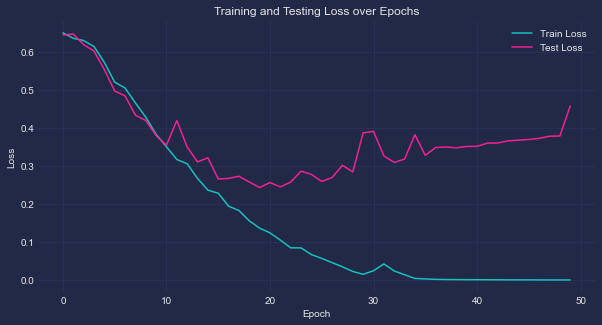

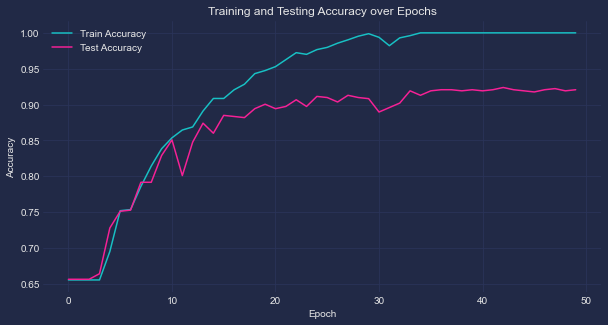

In [13]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-dark.mplstyle')
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

Видно, что точность не падает на тестовом наборе.
`Test Accuracy: 0.921` 

Ради любопытства предскажем класс питомца  Марси -- шпиц (собака), но выглядит как кошка. И тут модель верно предсказала.

На изображении собака.


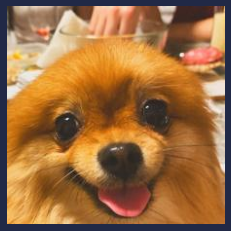

In [19]:
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  
    return image

image = Image.open("marsi.jpg")

new_size = (224, 224)
resized_image = image.resize(new_size)

resized_image.save("marsi.jpg")

image_path = "marsi.jpg"

image = preprocess_image(image_path).to(device)
with torch.no_grad():
    outputs = binary_model(image)
    _, predicted = torch.max(outputs, 1)

if predicted.item() == 0:
    print("На изображении кошка.")
else:
    print("На изображении собака.")

plt.imshow(resized_image)
plt.axis('off')
plt.show()

А вот это уже не мой питомец, а случайная кошка из интернета 

На изображении кошка.


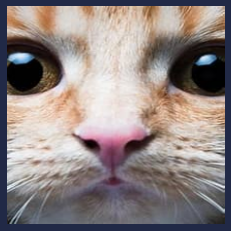

In [22]:
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    return image

image = Image.open("cotik.jpg")

new_size = (224, 224)
resized_image = image.resize(new_size)

resized_image.save("cotik.jpg")

image_path = "cotik.jpg"

image = preprocess_image(image_path).to(device)
with torch.no_grad():
    outputs = binary_model(image)
    _, predicted = torch.max(outputs, 1)

if predicted.item() == 0:
    print("На изображении кошка.")
else:
    print("На изображении собака.")

plt.imshow(resized_image)
plt.axis('off')
plt.show()

На всякий случай сохраним, чтобы повторно не запускать обучение.

In [20]:
model_path = "binary_model.pth"

torch.save(binary_model.state_dict(), model_path)

## Теперь решим задачу мультиклассовой классификации

In [2]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

data_dir = "petfaces"

image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

train_indices, test_indices = train_test_split(list(range(len(image_dataset))), test_size=0.2, stratify=image_dataset.targets, random_state=42)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32
train_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=test_sampler)

In [3]:
print(f"Количество классов в train: {len(train_loader.dataset.classes)} \nКоличество классов в test: {len(test_loader.dataset.classes)}")

Количество классов в train: 35 
Количество классов в test: 35


In [26]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [54]:
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
binary_model = MultiClassClassifier(len(train_loader.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(binary_model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
test_top3_accuracy = []
train_top3_accuracy = [] 

num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    top3_correct_train = 0 
    binary_model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = binary_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
 
        _, predicted_top3 = torch.topk(outputs, k=3, dim=1)
        for i in range(labels.size(0)):
            if labels[i] in predicted_top3[i]:
                top3_correct_train += 1
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)
    train_top3_accuracy.append(top3_correct_train / total_train)  

    running_loss = 0.0
    top3_correct_test = 0.0
    correct_test = 0
    total_test = 0
    binary_model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = binary_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.topk(outputs, k=3, dim=1)
            total_test += labels.size(0)
            
            for i in range(labels.size(0)):
                if labels[i] in predicted[i]:
                    top3_correct_test += 1
            
            _, predicted_top1 = torch.max(outputs, 1)
            correct_test += (predicted_top1 == labels).sum().item()
   
            
   

    test_losses.append(running_loss / len(test_loader))
    test_accuracy.append(correct_test / total_test)
    test_top3_accuracy.append(top3_correct_test / total_test)  # Рассчитываем top-3 точность и добавляем в список


    print('[%d] Train Loss: %.3f, Test Loss: %.3f, Train Accuracy: %.3f, Train Top-3 Accuracy: %.3f, Test Accuracy: %.3f, Test Top-3 Accuracy: %.3f' %
            (epoch + 1, train_losses[-1], test_losses[-1], train_accuracy[-1], train_top3_accuracy[-1], test_accuracy[-1],test_top3_accuracy[-1]))

print('Finished Training')


[1] Train Loss: 3.545, Test Loss: 3.523, Train Accuracy: 0.054, Train Top-3 Accuracy: 0.137, Test Accuracy: 0.065, Test Top-3 Accuracy: 0.160
[2] Train Loss: 3.489, Test Loss: 3.442, Train Accuracy: 0.061, Train Top-3 Accuracy: 0.174, Test Accuracy: 0.075, Test Top-3 Accuracy: 0.194
[3] Train Loss: 3.267, Test Loss: 3.060, Train Accuracy: 0.101, Train Top-3 Accuracy: 0.287, Test Accuracy: 0.194, Test Top-3 Accuracy: 0.376
[4] Train Loss: 2.859, Test Loss: 2.806, Train Accuracy: 0.218, Train Top-3 Accuracy: 0.429, Test Accuracy: 0.250, Test Top-3 Accuracy: 0.442
[5] Train Loss: 2.559, Test Loss: 2.662, Train Accuracy: 0.279, Train Top-3 Accuracy: 0.520, Test Accuracy: 0.260, Test Top-3 Accuracy: 0.481
[6] Train Loss: 2.296, Test Loss: 2.658, Train Accuracy: 0.363, Train Top-3 Accuracy: 0.593, Test Accuracy: 0.294, Test Top-3 Accuracy: 0.504
[7] Train Loss: 2.105, Test Loss: 2.468, Train Accuracy: 0.415, Train Top-3 Accuracy: 0.648, Test Accuracy: 0.356, Test Top-3 Accuracy: 0.577
[8] Tr

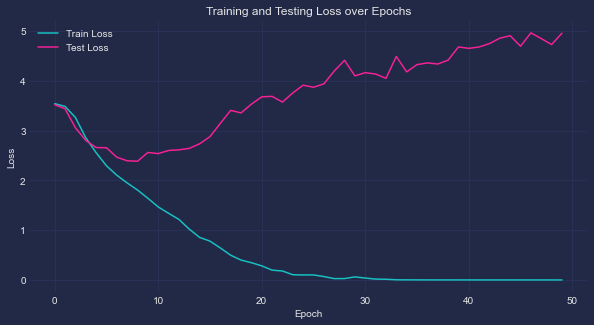

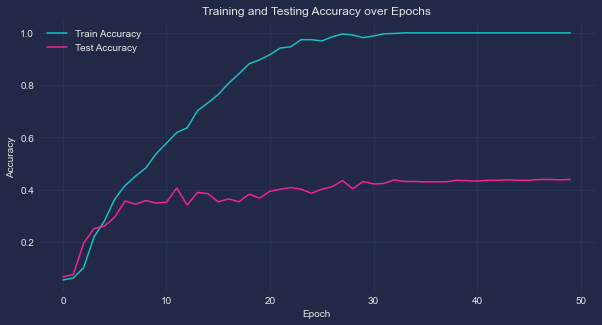

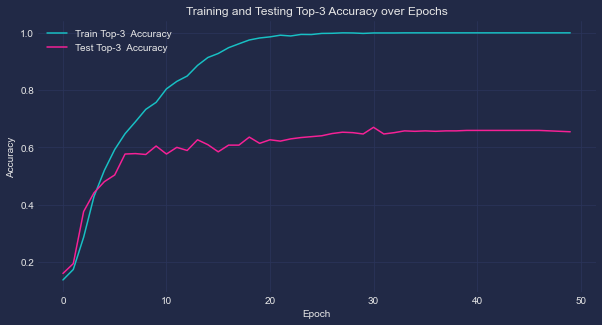

In [56]:
plt.style.use('https://raw.githubusercontent.com/dhaitz/matplotlib-stylesheets/master/pitayasmoothie-dark.mplstyle')
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_top3_accuracy, label='Train Top-3  Accuracy')
plt.plot(test_top3_accuracy, label='Test Top-3  Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Top-3 Accuracy over Epochs')
plt.legend()
plt.show()

Видим, что точность модели на тестовой выборке не падает. Топ 3 точность тоже не падает.
`Test Accuracy: 0.439, Test Top-3 Accuracy: 0.655`

In [57]:
model_path = "multi_model.pth"

torch.save(binary_model.state_dict(), model_path)

Этого класса нет в наборе данных, но очень интересно посмотреть на какую породу (кроме истинной) похоже мой питомец

Топ-5 наиболее вероятных пород:
dog_staffordshire: 0.89418
dog_chihuahua: 0.09232
dog_english: 0.01348
cat_Bengal: 0.00001
dog_american: 0.00001


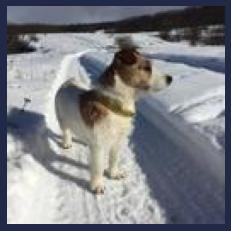

In [88]:
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    return image


image = Image.open("jasmin.jpg")

new_size = (128, 128)
resized_image = image.resize(new_size)

resized_image.save("jasmin.jpg")

image_path = "jasmin.jpg"

image = preprocess_image(image_path).to(device)


with torch.no_grad():
    outputs = binary_model(image)
    probabilities = torch.softmax(outputs, dim=1)
    _, predicted_indices = torch.topk(outputs, k=5, dim=1)

predicted_indices = predicted_indices.squeeze(0).cpu().tolist()  

class_names = image_dataset.classes

print("Топ-5 наиболее вероятных пород:")
top_5_breeds = [class_names[idx] for idx in predicted_indices]
top_5_probabilities = [probabilities[0, idx].item() for idx in predicted_indices]
for breed, prob in zip(top_5_breeds, top_5_probabilities):
    print(f"{breed}: {prob:.5f}")

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

Я вспомнил, что иногда к общаге приходит кормиться уличная кошка 

Топ-5 наиболее вероятных пород:
cat_Ragdoll: 0.85650
dog_basset: 0.11337
cat_British: 0.02859
dog_japanese: 0.00072
dog_english: 0.00058


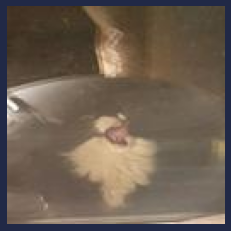

In [89]:
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0) 
    return image


image = Image.open("cotik_ob.jpg")

new_size = (128, 128)
resized_image = image.resize(new_size)
resized_image.save("cotik_ob.jpg")
image_path = "cotik_ob.jpg"

image = preprocess_image(image_path).to(device)


with torch.no_grad():
    outputs = binary_model(image)
    probabilities = torch.softmax(outputs, dim=1)
    _, predicted_indices = torch.topk(outputs, k=5, dim=1)

predicted_indices = predicted_indices.squeeze(0).cpu().tolist()  

class_names = image_dataset.classes

print("Топ-5 наиболее вероятных пород:")
top_5_breeds = [class_names[idx] for idx in predicted_indices]
top_5_probabilities = [probabilities[0, idx].item() for idx in predicted_indices]
for breed, prob in zip(top_5_breeds, top_5_probabilities):
    print(f"{breed}: {prob:.5f}")

image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

## confusion matrix

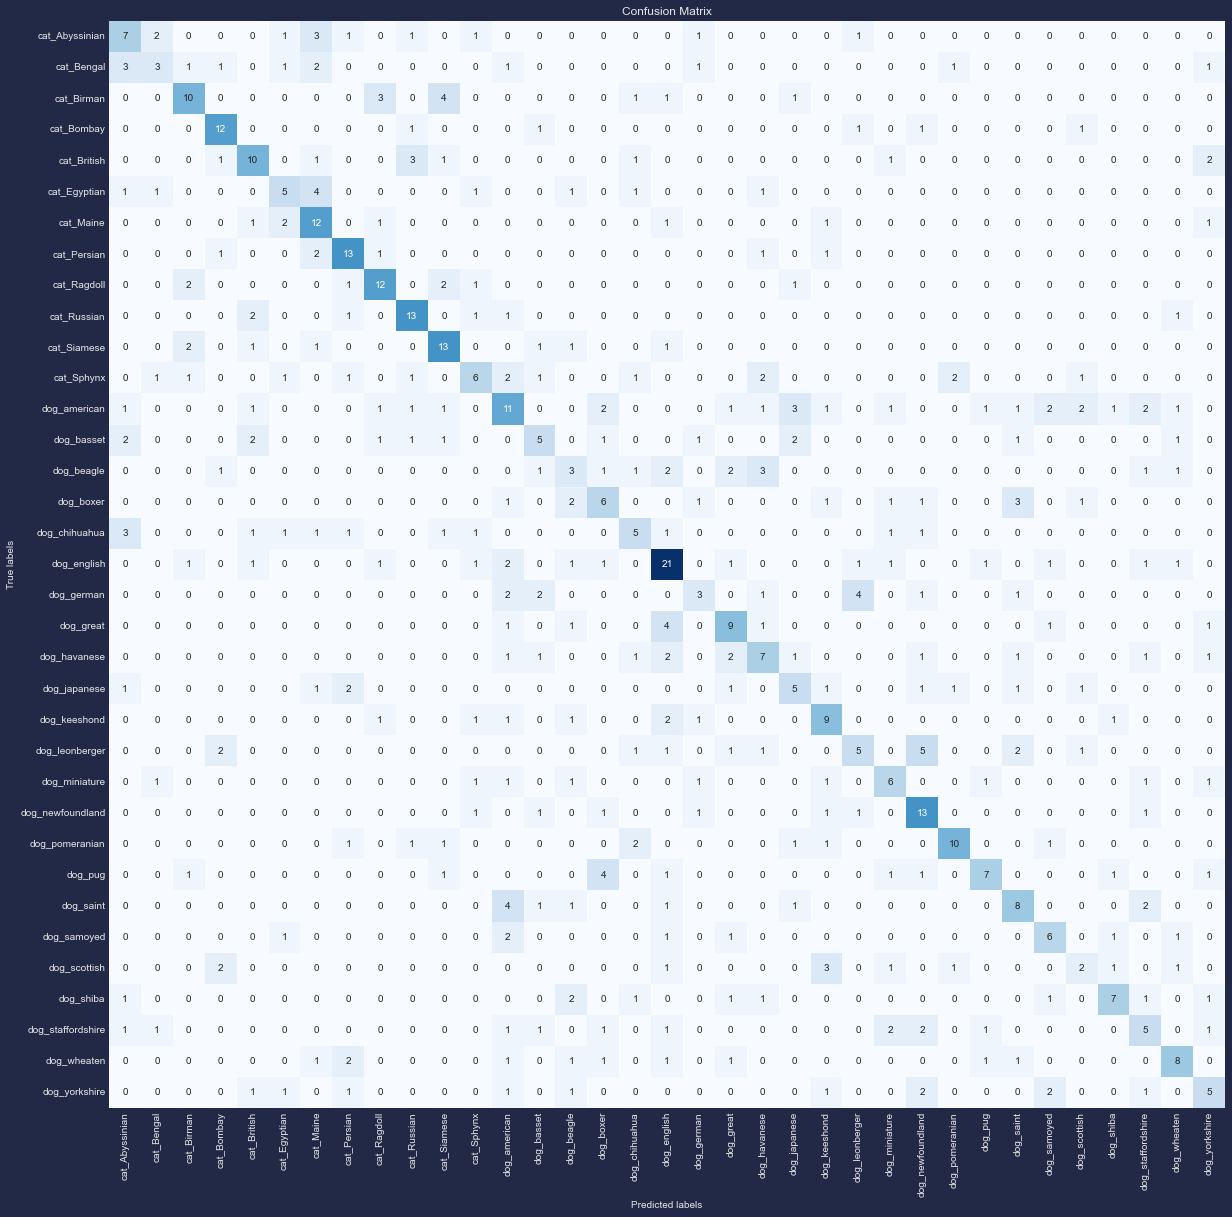

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = image_dataset.classes

true_labels = []
predicted_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

binary_model.to(device)

binary_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = binary_model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



## Оптимизация гиперпараметров

Выполнить оптимизацию гиперпараметров: архитектуры сети, learning rate, количества нейронов и размеров фильтров.

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split


data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])


data_dir = "petfaces"

image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

train_indices, test_indices = train_test_split(list(range(len(image_dataset))), test_size=0.2, stratify=image_dataset.targets, random_state=42)

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 32
train_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=test_sampler)

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes, architecture=(3, 32, 64, 128), kernel_sizes=(3, 3, 3), pool_size=2, fc_size=512, lr=0.001):
        super(MultiClassClassifier, self).__init__()

        in_channels, conv1_channels, conv2_channels, conv3_channels = architecture
        conv1_kernel, conv2_kernel, conv3_kernel = kernel_sizes

        self.conv1 = nn.Conv2d(in_channels, conv1_channels, kernel_size=conv1_kernel, padding=1)
        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=conv2_kernel, padding=1)
        self.conv3 = nn.Conv2d(conv2_channels, conv3_channels, kernel_size=conv3_kernel, padding=1)
        self.pool = nn.MaxPool2d(pool_size, pool_size)
        self.fc1 = nn.Linear(conv3_channels * 16 * 16, fc_size)
        self.fc2 = nn.Linear(fc_size, num_classes)

        self.lr = lr

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



In [68]:
import torch.optim as optim

num_classes = len(train_loader)
architectures = [(3, 32, 64, 128), (3, 64, 128, 256)]   
kernel_sizes = [(3, 3, 3)]
fc_sizes = [512, 1024] 
learning_rates  = [0.01, 0.001]


for architecture in architectures:
    for lr in learning_rates:
        for fc_size in fc_sizes:
            for kernel_size in kernel_sizes:

                model = MultiClassClassifier(num_classes, architecture=architecture, kernel_sizes=kernel_size, pool_size=2, fc_size=fc_size, lr=lr)
                max_test = 0
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                model.to(device)

                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)


                num_epochs = 5
                for epoch in range(num_epochs):
                    running_loss = 0.0
                    for i, data in enumerate(train_loader, 0):
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)  

                        optimizer.zero_grad()

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()

                        running_loss += loss.item()



                    correct_train = 0
                    total_train = 0
                    with torch.no_grad():
                        for data in train_loader:
                            images, labels = data
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            _, predicted = torch.max(outputs.data, 1)
                            total_train += labels.size(0)
                            correct_train += (predicted == labels).sum().item()


                    correct_test = 0
                    total_test = 0
                    with torch.no_grad():
                        for data in test_loader:
                            images, labels = data
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            _, predicted = torch.max(outputs.data, 1)
                            total_test += labels.size(0)
                            correct_test += (predicted == labels).sum().item()

                    if max_test < correct_test / total_test:
                        max_test = correct_test / total_test

                    print('[%d] Train Accuracy: %d %% | Test Accuracy: %d %% |' % (epoch + 1, 100 * correct_train / total_train, 100 * correct_test / total_test))
                print(f'For architecture = {architecture}, kernel_size = {kernel_size}, fc_size = {fc_size}, lr = {lr} Max Test Accuracy: {max_test}')

print('Finished Training')


[1] Train Accuracy: 4 % | Test Accuracy: 5 % |
[2] Train Accuracy: 16 % | Test Accuracy: 12 % |
[3] Train Accuracy: 30 % | Test Accuracy: 22 % |
[4] Train Accuracy: 45 % | Test Accuracy: 30 % |
[5] Train Accuracy: 56 % | Test Accuracy: 30 % |
For architecture = (3, 32, 64, 128), kernel_size = (3, 3, 3), fc_size = 512, lr = 0.01 Max Test Accuracy: 0.30637636080870917
[1] Train Accuracy: 5 % | Test Accuracy: 5 % |
[2] Train Accuracy: 5 % | Test Accuracy: 5 % |
[3] Train Accuracy: 5 % | Test Accuracy: 5 % |
[4] Train Accuracy: 5 % | Test Accuracy: 5 % |
[5] Train Accuracy: 5 % | Test Accuracy: 5 % |
For architecture = (3, 32, 64, 128), kernel_size = (3, 3, 3), fc_size = 1024, lr = 0.01 Max Test Accuracy: 0.05598755832037325
[1] Train Accuracy: 33 % | Test Accuracy: 26 % |
[2] Train Accuracy: 61 % | Test Accuracy: 39 % |
[3] Train Accuracy: 78 % | Test Accuracy: 42 % |
[4] Train Accuracy: 95 % | Test Accuracy: 47 % |
[5] Train Accuracy: 98 % | Test Accuracy: 49 % |
For architecture = (3, 3

Лучший набор гиперпараметров: 
- входной канал имеет размер 3, а сеть состоит из трех последовательных сверточных слоев с количеством фильтров 64, 128 и 256 соответственно.
- (3, 3, 3) указывает на размеры ядер свертки для каждого сверточного слоя. 
- 512 означает, что размер скрытого слоя полносвязного слоя составляет 512 нейронов. 
- lr = 0.001

`Max Test Accuracy: 0.5318818040435459`